# Find Tickers
We would like to identify cointegrated pairs.


In this example we will look at Utilities. The flow of this file is as follows

1. Read the tickers from the list we made
2. Look at only those where volume is greater than 1000000 for high liquidity
3. Drop missing values
4. Perform coint test and get those with p_value less than 0.05 


In [1]:
import json
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn
from statsmodels.tsa.stattools import coint

In [2]:
filename='data/utilities.csv'
df = pd.read_csv(filename, index_col = 0)
df.head()

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,PCG,PG&E Corporation,17.41,0.11,+0.64%,12.124M,17.942M,43.547B,18.92,NaN
1,NEE,"NextEra Energy, Inc.",67.59,-0.65,-0.95%,8.213M,8.109M,136.783B,16.69,NaN
2,AES,The AES Corporation,16.76,-0.32,-1.87%,6.051M,5.569M,11.223B,NaN,NaN
3,XEL,Xcel Energy Inc.,58.52,0.53,+0.91%,7.502M,4.008M,32.276B,18.58,NaN
4,VST,Vistra Corp.,33.15,-0.13,-0.40%,4.38M,4.637M,12.185B,9.36,NaN


In [3]:
df.shape

(85, 10)

We want to trade with stocks with adequate demand from buyers and sellers, we can eliminate others by defining a cap for the trade volume.

In [4]:
def convert_volume(value):
    if 'M' in value:
        return float(value.replace('M', '')) * 1e6  # Convert to millions
    elif 'k' in value:
        return float(value.replace('k', '')) * 1e3  # Convert to thousands
    else:
        return float(value)  # No conversion needed

# Apply the conversion function to the 'Volume' column
df['Volume'] = df['Volume'].apply(convert_volume)

In [5]:
 # Define a volume cap
volume_cap = 1000000

df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
df['Price (Intraday)'] = pd.to_numeric(df['Price (Intraday)'], errors='coerce')

df = df[['Symbol','Volume','Price (Intraday)']].sort_values(by='Volume', ascending=False)

high_volume = df["Volume"]>volume_cap
df_h = df[high_volume]
tickers = df_h.Symbol.tolist()
tickers

['PCG',
 'NEE',
 'XEL',
 'AES',
 'CNP',
 'VST',
 'NI',
 'EXC',
 'D',
 'SO',
 'DUK',
 'FE',
 'PPL',
 'CMS',
 'PEG',
 'AEP',
 'EVRG',
 'CEG',
 'SRE',
 'EIX',
 'ES',
 'LNT',
 'WEC',
 'DTE',
 'AEE',
 'ED']

### Download Price Data
We will use yfinance (https://pypi.org/project/yfinance/) to downloed the closing prices of stocks.
More information is available on the next notebook which we will download and save a more detailed stock data.

In [6]:
#!pip install <library_name>
#period = '1y' #valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
#interval = '1d' #valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
#df = yf.download(tickers, period=period, interval=interval)["Close"]


# Enable to use start & end dates:
start = datetime.date.today() - datetime.timedelta(days=430)
end = datetime.date.today() - datetime.timedelta(days=60)

df = yf.download(tickers, start, end)["Close"]

df.info()

[*********************100%%**********************]  26 of 26 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2022-07-18 to 2023-07-20
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AEE     254 non-null    float64
 1   AEP     254 non-null    float64
 2   AES     254 non-null    float64
 3   CEG     254 non-null    float64
 4   CMS     254 non-null    float64
 5   CNP     254 non-null    float64
 6   D       254 non-null    float64
 7   DTE     254 non-null    float64
 8   DUK     254 non-null    float64
 9   ED      254 non-null    float64
 10  EIX     254 non-null    float64
 11  ES      254 non-null    float64
 12  EVRG    254 non-null    float64
 13  EXC     254 non-null    float64
 14  FE      254 non-null    float64
 15  LNT     254 non-null    float64
 16  NEE     254 non-null    float64
 17  NI      254 non-null    float64
 18  PCG     254 non-null    float64
 19  PEG     254 non-null   

Check for null values and eliminate them
It is important to check the dataframe for Na rows & columns before moving forward. Downloaded data may not be consistent all the time, so better doing it manually before proceeding:


In [7]:
df.head()

,AEE,AEP,AES,CEG,CMS,CNP,D,DTE,DUK,ED,...,NEE,NI,PCG,PEG,PPL,SO,SRE,VST,WEC,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-18,86.419998,93.370003,20.280001,54.810001,64.809998,29.559999,78.010002,123.669998,105.430000,91.629997,...,77.510002,28.389999,10.35,60.060001,27.190001,71.690002,74.680000,22.820000,98.809998,68.550003
2022-07-19,86.470001,93.589996,20.620001,55.000000,64.959999,29.750000,77.779999,124.089996,105.540001,92.220001,...,78.930000,28.500000,10.69,60.410000,27.400000,71.750000,75.794998,23.629999,99.070000,68.860001
2022-07-20,85.849998,92.709999,19.980000,54.070000,63.880001,29.379999,75.769997,121.459999,102.989998,90.639999,...,78.320000,28.290001,10.70,59.639999,27.139999,70.940002,76.385002,23.639999,96.129997,67.599998
2022-07-21,86.309998,92.790001,19.910000,54.160000,63.919998,29.320000,75.959999,121.519997,103.540001,90.820000,...,78.870003,28.090000,10.58,59.599998,27.240000,70.849998,76.745003,23.360001,96.230003,67.699997
2022-07-22,87.430000,94.349998,19.730000,54.000000,65.180000,29.700001,77.349998,123.750000,104.980003,92.440002,...,80.250000,28.440001,10.63,60.099998,27.330000,71.940002,77.120003,23.000000,97.860001,68.669998


In [8]:
df = df.dropna(axis=0, how='all') # check if necessary
df = df.dropna(axis=1) # check if necessary
new_tickers = df.columns.tolist()
print(f"we have {len(new_tickers)} tickers left")
file_name = "data/utilities_close_prices.pkl"
df.to_pickle(file_name)
df.info()

we have 26 tickers left
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2022-07-18 to 2023-07-20
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AEE     254 non-null    float64
 1   AEP     254 non-null    float64
 2   AES     254 non-null    float64
 3   CEG     254 non-null    float64
 4   CMS     254 non-null    float64
 5   CNP     254 non-null    float64
 6   D       254 non-null    float64
 7   DTE     254 non-null    float64
 8   DUK     254 non-null    float64
 9   ED      254 non-null    float64
 10  EIX     254 non-null    float64
 11  ES      254 non-null    float64
 12  EVRG    254 non-null    float64
 13  EXC     254 non-null    float64
 14  FE      254 non-null    float64
 15  LNT     254 non-null    float64
 16  NEE     254 non-null    float64
 17  NI      254 non-null    float64
 18  PCG     254 non-null    float64
 19  PEG     254 non-null    float64
 20  PPL     254 non-null    float64
 

### Find Cointegrated Pairs

We will perfom cointegration tests for all of the pairs that we can produce from the available tickers. We still need to perform more detailed tests for stationarity in the following notebooks.

This function is designed to perform a statistical test called a cointegration test on a set of financial data, which typically represents the price movements of different assets or financial instruments (often referred to as "tickers"). Let me break down what this function does step by step:

`def cointegration_test(data, p_value=0.05)`:: This line defines a Python function called cointegration_test that takes two inputs: `data` and `p_value`. `data` is expected to be a dataset containing historical price or return data for multiple financial instruments (tickers), and `p_value` is a significance level used in the test, with a default value of 0.05 (commonly used in statistical testing).

`n = data.shape[1]`: This line calculates the number of columns (or financial instruments) in the input dataset data and assigns it to the variable n.

`stats = np.zeros((n, n))` and `pvalues = np.ones((n, n))`: These lines create two empty matrices (`stats` and `pvalues`) with dimensions n by n, where n is the number of financial instruments. These matrices will be filled with statistical results later.

`keys = data.keys()`: This line retrieves the names of the columns (financial instruments) in the input dataset and stores them in the keys variable.

`pairs = []`: This initializes an empty list called `pairs`. This list will store pairs of financial instruments that show significant cointegration.

The following nested for loops iterate through all possible combinations of financial instruments (tickers):

`for i in range(n)`:: This loop selects one financial instrument (ticker) as the first in a pair.
`for j in range(i+1, n)`:: This nested loop selects a different financial instrument as the second in a pair. The use of i+1 ensures that each pair is unique (e.g., it won't consider the same pair twice).
`result = coint(data[keys[i]], data[keys[j]])`: For each pair of financial instruments selected in the loops, this line calculates the cointegration test statistics and p-value using a function called `coint`. It compares the historical price or return data of the two instruments to see if they are cointegrated.

`test_stat = result[0] and pvalue = result[1]`: These lines extract the test statistic and p-value from the result of the cointegration test.

`stats[i, j] = test_stat and pvalues[i, j] = pvalue`: These lines store the test statistic and p-value in the corresponding positions in the stats and pvalues matrices.

`if pvalue < p_value:`: This line checks if the calculated p-value is less than the significance level (`p_value`). If it is, it means that the pair of financial instruments is statistically significant in terms of cointegration.

`pairs.append((keys[i], keys[j])):` If the pair is statistically significant, it is added to the pairs list, which keeps track of all such pairs.

Finally, the function returns three things:

`stats`: A matrix containing the cointegration test statistics for all pairs of financial instruments.
`pvalues`: A matrix containing the p-values for the cointegration test for all pairs.
`pairs`: A list of pairs of financial instruments that are statistically significant in terms of cointegration.
In summary, this function automates the process of testing whether pairs of financial instruments (tickers) are cointegrated, which can be useful for various quantitative trading and portfolio management strategies in finance. It collects and organizes the statistical results, making it easier for analysts and traders to identify pairs of assets that exhibit cointegration and may be suitable for trading strategies like pairs trading.

In [9]:
# let's define a function to loop through the tickers and do a cointegration test for each combination
def cointegration_test(data, p_value=0.05):
    n = data.shape[1]
    # create matrix to be filled later
    stats = np.zeros((n, n))
    pvalues = np.ones((n, n))
    keys = data.keys() # get the info axis, returns columns if object is a dataframe
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            test_stat = result[0]
            pvalue = result[1]
            stats[i, j] = test_stat
            pvalues[i, j] = pvalue

            if pvalue < p_value: # pick only statistically significant ones
                pairs.append((keys[i], keys[j]))

    return stats, pvalues, pairs

[('AEE', 'CNP'), ('AEP', 'DUK'), ('AEP', 'ES'), ('AEP', 'SRE'), ('CEG', 'CMS'), ('CEG', 'DUK'), ('CEG', 'EIX'), ('CEG', 'ES'), ('CEG', 'EVRG'), ('CEG', 'NI'), ('CEG', 'PEG'), ('CEG', 'PPL'), ('CEG', 'SO'), ('CEG', 'VST'), ('CEG', 'WEC'), ('CEG', 'XEL'), ('CNP', 'EVRG'), ('D', 'PCG'), ('DTE', 'LNT'), ('DUK', 'SRE'), ('DUK', 'XEL'), ('EVRG', 'WEC'), ('FE', 'PPL'), ('NI', 'PEG'), ('PCG', 'SRE'), ('SRE', 'XEL')]


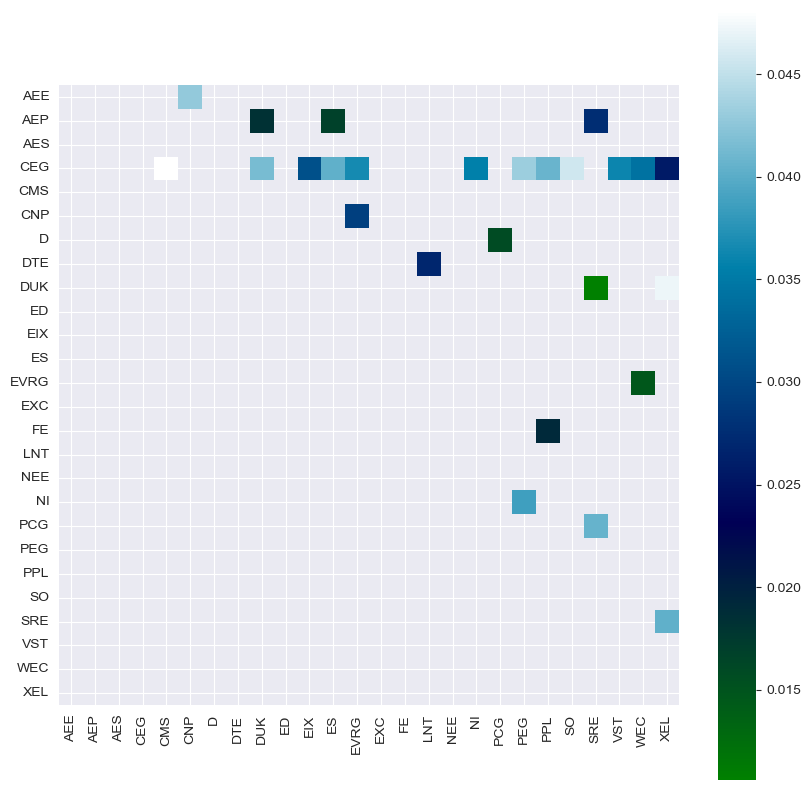

In [10]:
p_value = 0.05  # A p-value less than 0.05 is typically considered to be statistically significant

scores, pvalues, pairs = cointegration_test(df,p_value)

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    pvalues,
    xticklabels=new_tickers,
    yticklabels=new_tickers,
    cmap="ocean",
    mask=(pvalues >= 0.05),
    square=True
)
print(pairs)

### Filter For More Significant Pairs
Filter more to get more significant pairs, and eliminate empty cells.

,CMS,CNP,DUK,EIX,ES,EVRG,LNT,NI,PCG,PEG,PPL,SO,SRE,VST,WEC,XEL
AEE,nan,0.043,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AEP,nan,nan,0.018,nan,0.017,nan,nan,nan,nan,nan,nan,nan,0.027,nan,nan,nan
CEG,0.048,nan,0.042,0.031,0.040,0.037,nan,0.036,nan,0.043,0.041,0.046,nan,0.036,0.034,0.026
CNP,nan,nan,nan,nan,nan,0.029,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
D,nan,nan,nan,nan,nan,nan,nan,nan,0.016,nan,nan,nan,nan,nan,nan,nan
DTE,nan,nan,nan,nan,nan,nan,0.027,nan,nan,nan,nan,nan,nan,nan,nan,nan
DUK,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.011,nan,nan,0.047
EVRG,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.015,nan
FE,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.019,nan,nan,nan,nan,nan
NI,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.039,nan,nan,nan,nan,nan,nan


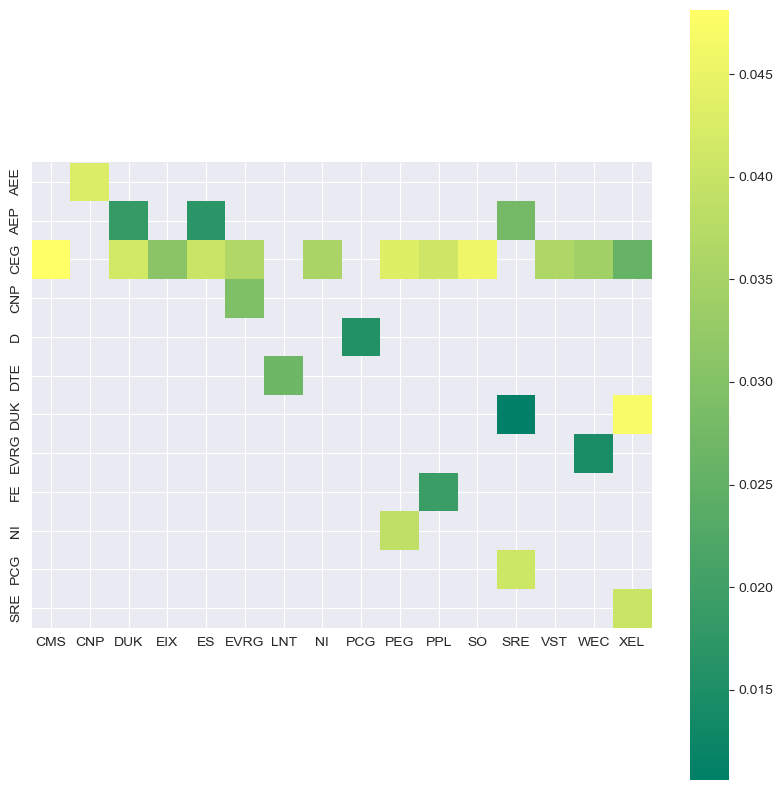

In [11]:
mask_matrix = (pvalues >= 0.05) # possible to increase the level of significance

mask_df = pd.DataFrame(mask_matrix, index= new_tickers, columns = new_tickers)
scores_df = pd.DataFrame(scores, index= new_tickers, columns = new_tickers)
pvalues_df = pd.DataFrame(pvalues, index= new_tickers, columns = new_tickers)

df_f = pvalues_df[~mask_df].dropna(how='all', axis=1)
df_f = df_f.dropna(how='all')

def gold_apply(x):
    color = {True: "background-color: #c78f2e", False: "color : white"}
    is_color = (x > 0).replace(color)
    return is_color


fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    df_f,
    xticklabels=df_f.columns,
    yticklabels=df_f.index,
    cmap="summer",
    square=True
)
df_f.style.format(precision=3) \
    .apply(gold_apply)

In [12]:
x_list = df_f.index.tolist()
y_list = df_f.columns.tolist()

new_pairs_list = [] # list of pairs as tuples (A,B)

for i in range(len(x_list)):
    for j in range(len(y_list)):
        if df_f.iloc[i,j]>0:
            new_pairs_list.append((x_list[i], y_list[j]))

new_pairs_list

[('AEE', 'CNP'),
 ('AEP', 'DUK'),
 ('AEP', 'ES'),
 ('AEP', 'SRE'),
 ('CEG', 'CMS'),
 ('CEG', 'DUK'),
 ('CEG', 'EIX'),
 ('CEG', 'ES'),
 ('CEG', 'EVRG'),
 ('CEG', 'NI'),
 ('CEG', 'PEG'),
 ('CEG', 'PPL'),
 ('CEG', 'SO'),
 ('CEG', 'VST'),
 ('CEG', 'WEC'),
 ('CEG', 'XEL'),
 ('CNP', 'EVRG'),
 ('D', 'PCG'),
 ('DTE', 'LNT'),
 ('DUK', 'SRE'),
 ('DUK', 'XEL'),
 ('EVRG', 'WEC'),
 ('FE', 'PPL'),
 ('NI', 'PEG'),
 ('PCG', 'SRE'),
 ('SRE', 'XEL')]

In [13]:
new_pairs_str =[] # list of pairs as string A-B

for column in df_f:
    toprint = df_f.index[df_f[column]>0].tolist()
    new_pairs_str.append([column + "-" + s for s in toprint])

new_pairs_str

[['CMS-CEG'],
 ['CNP-AEE'],
 ['DUK-AEP', 'DUK-CEG'],
 ['EIX-CEG'],
 ['ES-AEP', 'ES-CEG'],
 ['EVRG-CEG', 'EVRG-CNP'],
 ['LNT-DTE'],
 ['NI-CEG'],
 ['PCG-D'],
 ['PEG-CEG', 'PEG-NI'],
 ['PPL-CEG', 'PPL-FE'],
 ['SO-CEG'],
 ['SRE-AEP', 'SRE-DUK', 'SRE-PCG'],
 ['VST-CEG'],
 ['WEC-CEG', 'WEC-EVRG'],
 ['XEL-CEG', 'XEL-DUK', 'XEL-SRE']]

In [14]:
new_pairs_dic= {} # list of pairs as dictionary {'A':['B','C']}

for column in df_f:
    new_pairs_dic[column] = df_f.index[df_f[column]>0].tolist()

new_pairs_dic

{'CMS': ['CEG'],
 'CNP': ['AEE'],
 'DUK': ['AEP', 'CEG'],
 'EIX': ['CEG'],
 'ES': ['AEP', 'CEG'],
 'EVRG': ['CEG', 'CNP'],
 'LNT': ['DTE'],
 'NI': ['CEG'],
 'PCG': ['D'],
 'PEG': ['CEG', 'NI'],
 'PPL': ['CEG', 'FE'],
 'SO': ['CEG'],
 'SRE': ['AEP', 'DUK', 'PCG'],
 'VST': ['CEG'],
 'WEC': ['CEG', 'EVRG'],
 'XEL': ['CEG', 'DUK', 'SRE']}

### Save to file
Save dataframa as pickle to use for the next steps

In [15]:
df_f.to_pickle("data/pairs_to_download.pkl")

In [16]:
new_pairs_dic

{'CMS': ['CEG'],
 'CNP': ['AEE'],
 'DUK': ['AEP', 'CEG'],
 'EIX': ['CEG'],
 'ES': ['AEP', 'CEG'],
 'EVRG': ['CEG', 'CNP'],
 'LNT': ['DTE'],
 'NI': ['CEG'],
 'PCG': ['D'],
 'PEG': ['CEG', 'NI'],
 'PPL': ['CEG', 'FE'],
 'SO': ['CEG'],
 'SRE': ['AEP', 'DUK', 'PCG'],
 'VST': ['CEG'],
 'WEC': ['CEG', 'EVRG'],
 'XEL': ['CEG', 'DUK', 'SRE']}

In [17]:
# Define the file path
file_path = "data/pairs_names.json"

# Save the dictionary to the JSON file
with open(file_path, "w") as json_file:
    json.dump(new_pairs_dic, json_file)